In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('../prcp_monthly.csv')
data['month'] = pd.to_datetime(data['month'])
data.index = pd.date_range(start='2001-01-01', end='2020-12-31', freq='ME')
data.head()

,index,month,prcp
2001-01-31,0,2001-01-01,101.400000
2001-02-28,1,2001-02-01,98.200000
2001-03-31,2,2001-03-01,201.200000
2001-04-30,3,2001-04-01,141.200000
2001-05-31,4,2001-05-01,29.233333


Train test split:

In [39]:
train = data[data['month'].dt.year <= 2015]
test = data[data['month'].dt.year > 2015]

## 1. Simple ETS

##### Auto fit:

In [ ]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

model = ETSModel(train['prcp'], error="add", trend="add", seasonal="add", seasonal_periods=12)
fit = model.fit()
print(fit.summary())


                                 ETS Results                                  
Dep. Variable:                   prcp   No. Observations:                  180
Model:                       ETS(AAA)   Log Likelihood                -938.064
Date:                Sat, 22 Feb 2025   AIC                           1912.129
Time:                        22:10:24   BIC                           1969.602
Sample:                    01-31-2001   HQIC                          1935.432
                         - 12-31-2015   Scale                         1968.567
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.3447      0.066      5.184      0.000       0.214       0.475
smoothing_trend      3.447e-05        nan        nan        nan         nan         nan
smoothing_season

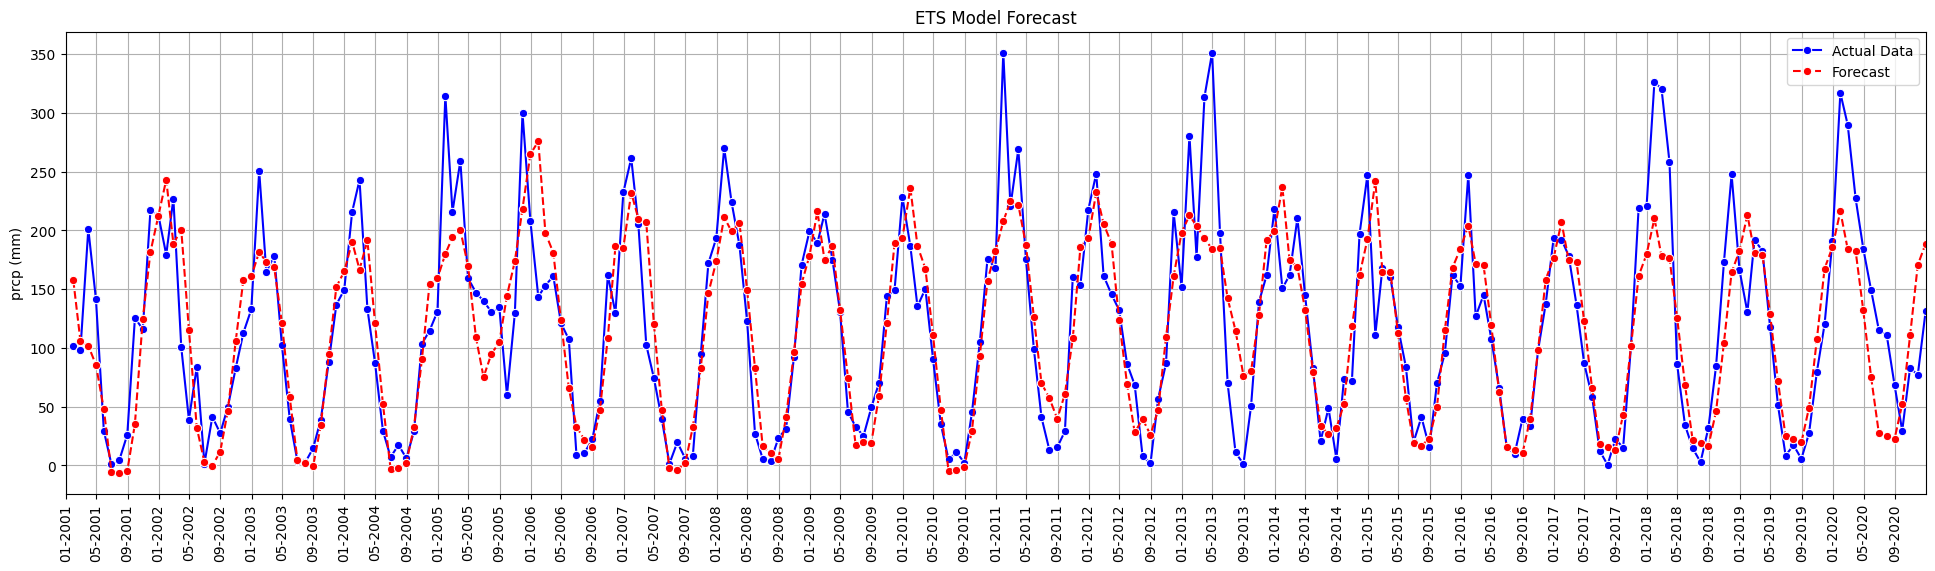

In [122]:
import seaborn as sns
import matplotlib.dates as mdates

forecast = fit.forecast(steps=len(test))
fitted_values = pd.concat([fit.fittedvalues, forecast])
fitted_values.index = pd.date_range(start='2001-01-01', end='2020-12-31', freq='ME')

plt.figure(figsize=(24, 6))
sns.lineplot(data["prcp"], label="Actual Data", color="blue", marker="o")
sns.lineplot(fitted_values, label="Forecast", color="red", linestyle="dashed", marker='o')
plt.xlim(pd.to_datetime("2001-01-01"), pd.to_datetime("2020-12-31"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4)) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.xticks(rotation=90)  
plt.grid(True)
plt.ylabel("prcp (mm)")
plt.title("ETS Model Forecast")
plt.legend()
# plt.savefig('../forecast/quarterly_ordinary_quadratic_model.png')
plt.show()

Evaluate:

In [123]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(test['prcp'], forecast)
rmse = mse ** 0.5
mae = mean_absolute_error(test['prcp'], forecast)
r2 = r2_score(test['prcp'], forecast)
aic = best_model.aic
bic = best_model.bic

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")
print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")

MSE: 2441.13
RMSE: 49.41
MAE: 36.47
R²: 0.690
AIC: 1870.13
BIC: 1927.60


##### Grid search:

In [11]:
import itertools
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import r2_score

error_types = ["add", "mul"]
trend_types = [None, "add", "mul"]
seasonal_types = [None, "add", "mul"]

models = []
aics = []
r2s = []

for error, trend, seasonal in itertools.product(error_types, trend_types, seasonal_types):
    model = ETSModel(train['prcp'], error=error, trend=trend, seasonal=seasonal, seasonal_periods=12).fit()
    models.append(model)
    aics.append(model.aic)
    forecast = model.forecast(steps=len(test))
    r2s.append(r2_score(test['prcp'], forecast))


c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


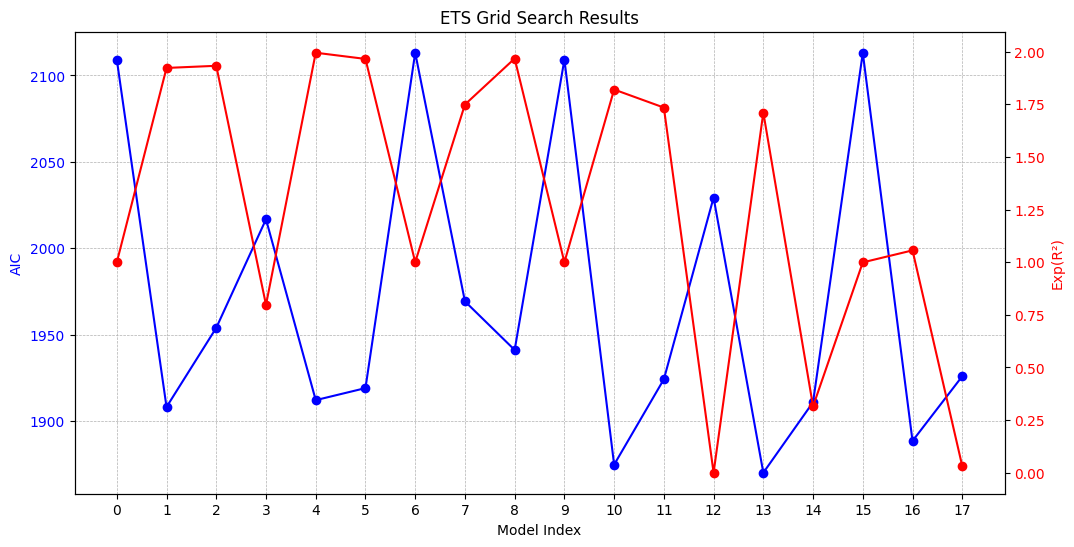

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Tạo figure
fig, ax1 = plt.subplots(figsize=(12, 6))

# Trục y thứ nhất (trái) - AIC
ax1.plot(aics, color="blue", marker="o", label="AIC")
ax1.set_xlabel("Model Index")
ax1.set_ylabel("AIC", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.set_xticks(range(0, 19))
ax1.grid(True, which="both", linestyle="--", linewidth=0.5)

# Tạo trục y thứ hai (phải) - Exp(R²)
ax2 = ax1.twinx()
ax2.plot(np.exp(r2s), color="red", marker="o", label="Exp(R²)")
ax2.set_ylabel("Exp(R²)", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Tiêu đề
plt.title("ETS Grid Search Results")

# plt.savefig('ets_grid_search.png')
plt.show()


- Due to the graph, we will choose 4th model

In [6]:
best_model = models[4]
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:                   prcp   No. Observations:                  180
Model:                       ETS(AAA)   Log Likelihood                -938.064
Date:                Sun, 23 Feb 2025   AIC                           1912.129
Time:                        08:15:08   BIC                           1969.602
Sample:                    01-31-2001   HQIC                          1935.432
                         - 12-31-2015   Scale                         1968.567
Covariance Type:               approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.3447      0.066      5.184      0.000       0.214       0.475
smoothing_trend      3.447e-05        nan        nan        nan         nan         nan
smoothing_seasonal   6.553e-05        nan        nan        nan         nan         nan
initial_level         157.3954     32.589      4.830      0.000      93.522     221.269
initial_trend           0.2562      1.167      0.220      0.826      -2.030       2.543
initial_seasonal.0    -30.3362     10.222     -2.968      0.003     -50.371     -10.302
initial_seasonal.1    -48.4331     10.178     -4.758      0.000     -68.382     -28.484
initial_seasonal.2   -107.9952     10.166    -10.623      0.000    -127.920     -88.070
initial_seasonal.3   -166.2777     10.192    -16.314      0.000    -186.255    -146.301
initial_seasonal.4   -195.5399     10.117    -19.329      0.000    -215.368    -175.712
initial_seasonal.5   -192.8197      9.660    -19.961      0.000    -211.752    -173.887
initial_seasonal.6   -189.9944      9.472    -20.058      0.000    -208.560    -171.429
initial_seasonal.7   -142.6054      9.707    -14.691      0.000    -161.631    -123.580
initial_seasonal.8    -85.1990     10.060     -8.469      0.000    -104.917     -65.481
initial_seasonal.9    -34.3559      9.655     -3.558      0.000     -53.280     -15.432
initial_seasonal.10   -32.6261      9.759     -3.343      0.001     -51.753     -13.499
initial_seasonal.11          0      9.898          0      1.000     -19.400      19.400
===================================================================================
Ljung-Box (Q):                       24.27   Jarque-Bera (JB):                30.96
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               1.23   Skew:                             0.30
Prob(H) (two-sided):                  0.43   Kurtosis:                         4.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number  1e+18. Standard errors may be unstable.
"""

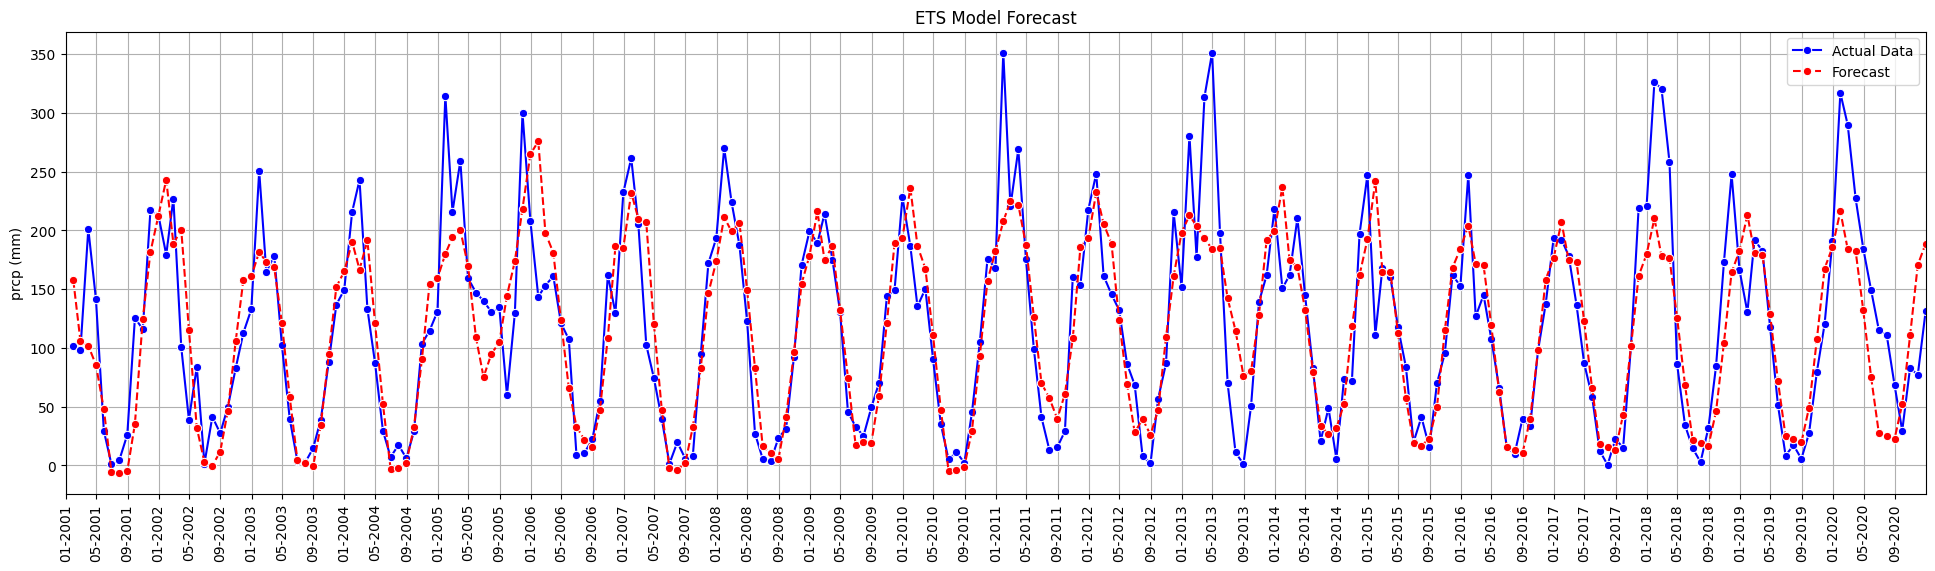

In [ ]:
import seaborn as sns
import matplotlib.dates as mdates

forecast = best_model.forecast(steps=len(test))
fitted_values = pd.concat([best_model.fittedvalues, forecast])
fitted_values.index = pd.date_range(start='2001-01-01', end='2020-12-31', freq='ME')

plt.figure(figsize=(24, 6))
sns.lineplot(data["prcp"], label="Actual Data", color="blue", marker="o")
sns.lineplot(fitted_values, label="Forecast", color="red", linestyle="dashed", marker='o')
plt.xlim(pd.to_datetime("2001-01-01"), pd.to_datetime("2020-12-31"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4)) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.xticks(rotation=90)  
plt.grid(True)
plt.ylabel("prcp (mm)")
plt.title("ETS Model Forecast")
plt.legend()
# plt.savefig('../forecast/simple_ets_model.png')
plt.show()

Evaluate best model:

In [143]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(test['prcp'], forecast)
rmse = mse ** 0.5
mae = mean_absolute_error(test['prcp'], forecast)
r2 = r2_score(test['prcp'], forecast)
aic = best_model.aic
bic = best_model.bic

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")
print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")

MSE: 2441.13
RMSE: 49.41
MAE: 36.47
R²: 0.690
AIC: 1912.13
BIC: 1969.60


- It turns out that the first model we tried is the best model.

## 2. Holt winters:

Grid search:

In [87]:
import itertools
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import r2_score

trend_types = [None, "add", "mul"]
seasonal_types = [None, "add", "mul"]

holt_models = []
aics = []
r2s = []

for trend, seasonal in itertools.product(trend_types, seasonal_types):
    model = ExponentialSmoothing(train['prcp'], trend=trend, damped_trend=trend is not None, seasonal=seasonal, seasonal_periods=12).fit()
    holt_models.append(model)
    aics.append(model.aic)
    forecast = model.forecast(steps=len(test))
    r2s.append(r2_score(test['prcp'], forecast))

c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Grid search results:

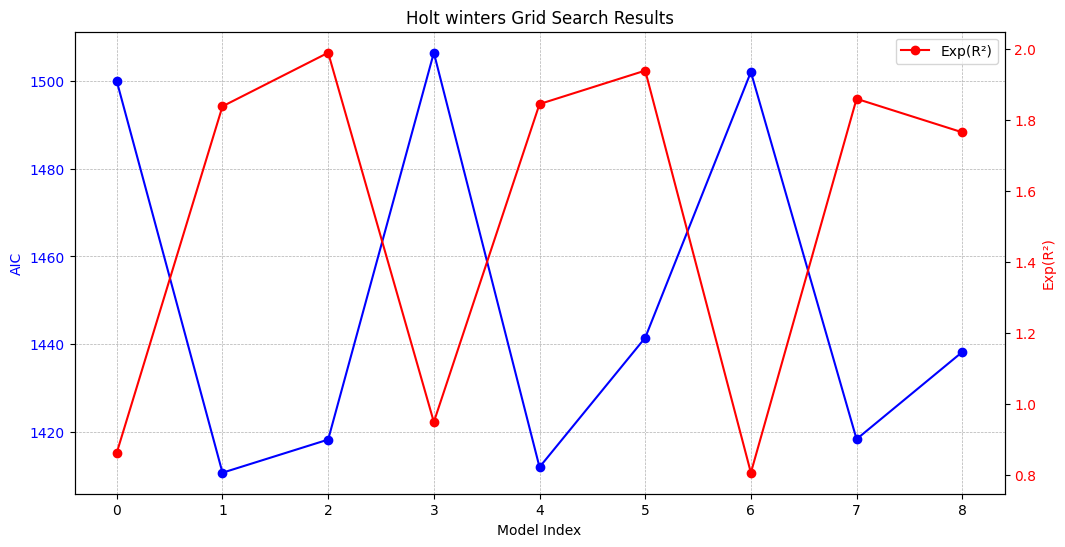

In [88]:
import matplotlib.pyplot as plt
import numpy as np

# Tạo figure
fig, ax1 = plt.subplots(figsize=(12, 6))

# Trục y thứ nhất (trái) - AIC
ax1.plot(aics, color="blue", marker="o", label="AIC")
ax1.set_xlabel("Model Index")
ax1.set_ylabel("AIC", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.set_xticks(range(0, 19))
ax1.grid(True, which="both", linestyle="--", linewidth=0.5)

# Tạo trục y thứ hai (phải) - Exp(R²)
ax2 = ax1.twinx()
ax2.plot(np.exp(r2s), color="red", marker="o", label="Exp(R²)")
ax2.set_ylabel("Exp(R²)", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Tiêu đề
plt.title("Holt winters Grid Search Results")
plt.legend()
# plt.savefig('holt_winters_grid_search.png')
plt.show()


As we can see, the 2th model yield best performance.

In [89]:
holt_models[2].summary()

Dep. Variable:,prcp,No. Observations:,180
Model:,ExponentialSmoothing,SSE,406898.123
Optimized:,True,AIC,1418.205
Trend:,None,BIC,1462.906
Seasonal:,Multiplicative,AICC,1421.542
Seasonal Periods:,12,Date:,"Thu, 27 Feb 2025"
Box-Cox:,False,Time:,13:36:41
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.0048612,alpha,True
smoothing_seasonal,0.0643156,gamma,True


Predict:

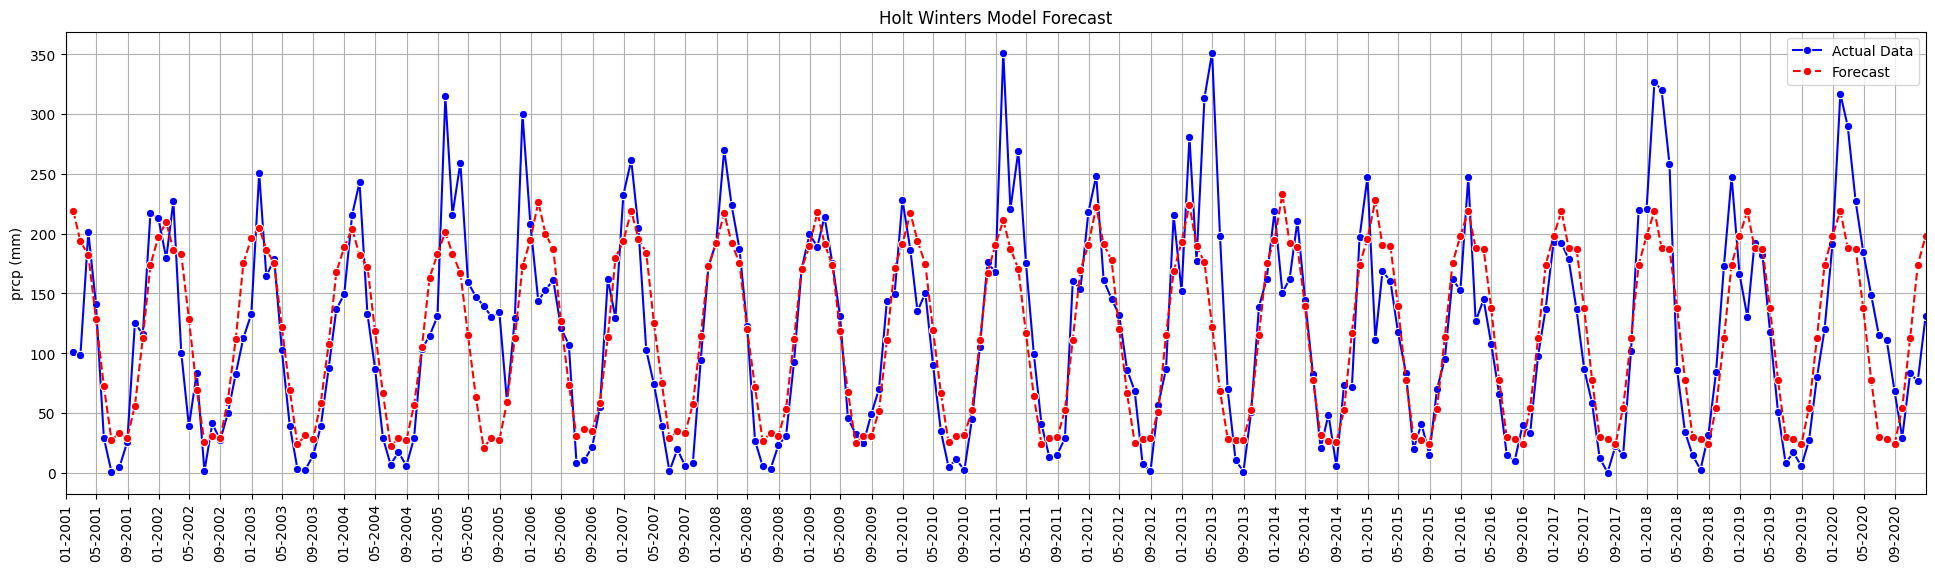

In [90]:
import seaborn as sns
import matplotlib.dates as mdates

holt = holt_models[2]

forecast = holt.forecast(steps=len(test))
fitted_values = pd.concat([holt.fittedvalues, forecast])
fitted_values.index = pd.date_range(start='2001-01-01', end='2020-12-31', freq='ME')

plt.figure(figsize=(24, 6))
sns.lineplot(data["prcp"], label="Actual Data", color="blue", marker="o")
sns.lineplot(fitted_values, label="Forecast", color="red", linestyle="dashed", marker='o')
plt.xlim(pd.to_datetime("2001-01-01"), pd.to_datetime("2020-12-31"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4)) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.xticks(rotation=90)  
plt.grid(True)
plt.ylabel("prcp (mm)")
plt.title("Holt Winters Model Forecast")
plt.legend()
# plt.savefig('../forecast/holt_winters_model.png')
plt.show()

Evaluate:

In [91]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(test['prcp'], forecast)
rmse = mse ** 0.5
mae = mean_absolute_error(test['prcp'], forecast)
r2 = r2_score(test['prcp'], forecast)
aic = holt.aic
bic = holt.bic

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")
print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")

MSE: 2459.18
RMSE: 49.59
MAE: 39.62
R²: 0.688
AIC: 1418.21
BIC: 1462.91
